# Import Required Libraries
Import necessary libraries such as NumPy, SciPy, OpenCV, TensorFlow, and others.

In [1]:
# Import necessary libraries
import os
import numpy as np
import scipy.io
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split

# Load File Names and Labels
Load the file names from cells2.txt and the labels from labels.mat using SciPy.

In [12]:
# Load File Names and Labels

# Load file names from cells2.txt
with open('cells2.txt', 'r') as file:
    file_names = file.read().splitlines()

# Load labels from labels.mat using SciPy
labels = scipy.io.loadmat('labels.mat')['labels'].flatten()

# Display the number of file names and labels loaded
print(f"Number of file names loaded: {len(file_names)}")
print(f"Number of labels loaded: {len(labels)}")

# Ensure that the number of file names matches the number of labels
assert len(file_names) == len(labels), "Mismatch between number of file names and labels"

Number of file names loaded: 63445
Number of labels loaded: 63445


# Check Image Sizes

In [21]:
import cv2
import numpy as np
import os

# Function to get the size of an image
def get_image_size(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        return image.shape[:2]  # Return height and width
    else:
        return None

# Load a batch of images and check their sizes
image_sizes = []
batch_size = 10000  # Number of images to analyze
for file in file_names[:batch_size]:
    size = get_image_size(file)
    if size is not None:
        image_sizes.append(size)

# Convert to numpy array for easier analysis
image_sizes = np.array(image_sizes)

# Display the number of images analyzed
num_images_analyzed = len(image_sizes)
print(f"Number of images analyzed: {num_images_analyzed}")

# Display the sizes of the images
print(f"Image sizes (height, width): {image_sizes}")

# Calculate mean and median dimensions
mean_height, mean_width = np.mean(image_sizes, axis=0)
median_height, median_width = np.median(image_sizes, axis=0)

# Display the mean and median dimensions
print(f"Mean dimensions of {num_images_analyzed} images: {mean_height:.2f} x {mean_width:.2f}")
print(f"Median dimensions of {num_images_analyzed} images: {median_height:.2f} x {median_width:.2f}")

Number of images analyzed: 10000
Image sizes (height, width): [[64 62]
 [71 68]
 [72 77]
 ...
 [69 66]
 [66 75]
 [75 66]]
Mean dimensions of 10000 images: 72.72 x 72.68
Median dimensions of 10000 images: 72.00 x 71.00


# Select a Subset of Images
Randomly select 1,000 images from the dataset for the project.

## Select 1,000 from the Total Amount

In [67]:
# Select a Subset of Images

# Randomly select 10,000 images from the dataset
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(file_names), 10000, replace=False)

# Get the selected file names and labels
selected_file_names = [file_names[i] for i in selected_indices]
selected_labels = labels[selected_indices]

# Display the number of selected file names and labels
print(f"Number of selected file names: {len(selected_file_names)}")
print(f"Number of selected labels: {len(selected_labels)}")

# Ensure that the number of selected file names matches the number of selected labels
assert len(selected_file_names) == len(selected_labels), "Mismatch between number of selected file names and labels"

Number of selected file names: 10000
Number of selected labels: 10000


## Select 1,000 from 1-10,000

In [6]:
# Filter the file names to ensure they are within the range 1-10,000
filtered_file_names = [file for file in file_names if int(os.path.basename(file).split('.')[0]) <= 10000]

# Randomly select 10,000 images from the filtered dataset
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(filtered_file_names), 10000, replace=False)

# Get the selected file names and labels
selected_file_names = [filtered_file_names[i] for i in selected_indices]
selected_labels = labels[selected_indices]

# Display the number of selected file names and labels
print(f"Number of selected file names: {len(selected_file_names)}")
print(f"Number of selected labels: {len(selected_labels)}")

# Ensure that the number of selected file names matches the number of selected labels
assert len(selected_file_names) == len(selected_labels), "Mismatch between number of selected file names and labels"

Number of selected file names: 10000
Number of selected labels: 10000


## Select 10,000

In [13]:
# Filter the file names to ensure they are within the range 1-10,000
filtered_file_names = [file for file in file_names if int(os.path.basename(file).split('.')[0]) <= 10000]

# Select the first 10,000 images from the filtered dataset
selected_file_names = filtered_file_names[:10000]
selected_labels = labels[:10000]

# Display the number of selected file names and labels
print(f"Number of selected file names: {len(selected_file_names)}")
print(f"Number of selected labels: {len(selected_labels)}")

# Ensure that the number of selected file names matches the number of selected labels
assert len(selected_file_names) == len(selected_labels), "Mismatch between number of selected file names and labels"

Number of selected file names: 10000
Number of selected labels: 10000


# Split Data into Training, Validation, and Testing Sets
Split the 1,000 images into 400 training, 300 validation, and 300 testing sets.

In [14]:
# Split Data into Training, Validation, and Testing Sets

# Split the selected file names and labels into training, validation, and testing sets
train_files, temp_files, train_labels, temp_labels = train_test_split(
    selected_file_names, selected_labels, test_size=0.6, random_state=42)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42)

# Display the number of files in each set
print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")
print(f"Number of testing files: {len(test_files)}")

# Ensure that the total number of files matches the number of selected files
assert len(train_files) + len(val_files) + len(test_files) == len(selected_file_names), "Mismatch in total number of files after splitting"

Number of training files: 4000
Number of validation files: 3000
Number of testing files: 3000


# Preprocess Images (Resizing and Normalization)
Resize images to a consistent size and normalize pixel values.

## Section 1. Define Target Size and Preprocess Function

In [14]:
# Define the target image size
target_size = (128, 128)

# Function to preprocess images: resize and normalize
def preprocess_image(image_path, target_size):
    # Read the image from the file
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Check if the image was read correctly
    if image is None:
        print(f"Error reading image: {image_path}")
        return None
    # Resize the image to the target size
    image_resized = cv2.resize(image, target_size)
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_resized / 255.0
    return image_normalized

## Section 1b. Preprocess Function for MobileNetV2

In [15]:
# Define the target image size
target_size = (96, 96)

# Function to preprocess images: resize, convert to grayscale, and normalize
def preprocess_image_for_sift(image_path, target_size):
    # Read the image from the file
    image = cv2.imread(image_path)
    # Check if the image was read correctly
    if image is None:
        print(f"Error reading image: {image_path}")
        return None
    # Resize the image to the target size
    image_resized = cv2.resize(image, target_size)
    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_gray / 255.0
    # Convert to uint8
    image_uint8 = (image_normalized * 255).astype(np.uint8)
    return image_uint8

## Section 2b. Preproceses, Training, Validation, and Testing Images for MobileNetV2 96x96

In [16]:
# Define the target image size based on the pre-trained model requirements
target_size = (96, 96)  # Example size for MobileNetV2

# Preprocess training images
train_images = [preprocess_image_for_sift(file, target_size) for file in train_files if preprocess_image_for_sift(file, target_size) is not None]

# Preprocess validation images
val_images = [preprocess_image_for_sift(file, target_size) for file in val_files if preprocess_image_for_sift(file, target_size) is not None]

# Preprocess testing images
test_images = [preprocess_image_for_sift(file, target_size) for file in test_files if preprocess_image_for_sift(file, target_size) is not None]

# Count the number of successfully preprocessed images
print(f"Number of successfully preprocessed training images: {len(train_images)}")
print(f"Number of successfully preprocessed validation images: {len(val_images)}")
print(f"Number of successfully preprocessed testing images: {len(test_images)}")

Number of successfully preprocessed training images: 4000
Number of successfully preprocessed validation images: 3000
Number of successfully preprocessed testing images: 3000


## Section 2. Preprocess Training, Validation, and Testing Images

In [32]:
# Preprocess training images
train_images = [preprocess_image(file, target_size) for file in train_files if preprocess_image(file, target_size) is not None]

# Preprocess validation images
val_images = [preprocess_image(file, target_size) for file in val_files if preprocess_image(file, target_size) is not None]

# Preprocess testing images
test_images = [preprocess_image(file, target_size) for file in test_files if preprocess_image(file, target_size) is not None]

# Count the number of successfully preprocessed images
print(f"Number of successfully preprocessed training images: {len(train_images)}")
print(f"Number of successfully preprocessed validation images: {len(val_images)}")
print(f"Number of successfully preprocessed testing images: {len(test_images)}")

Number of successfully preprocessed training images: 400
Number of successfully preprocessed validation images: 300
Number of successfully preprocessed testing images: 300


## Section 2.5 Verify Some of the Images

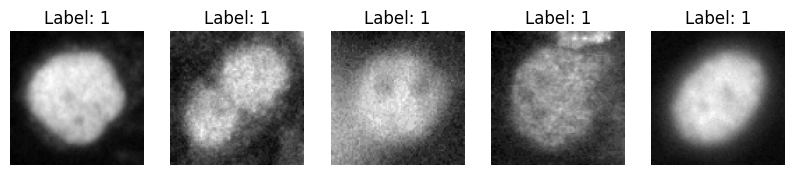

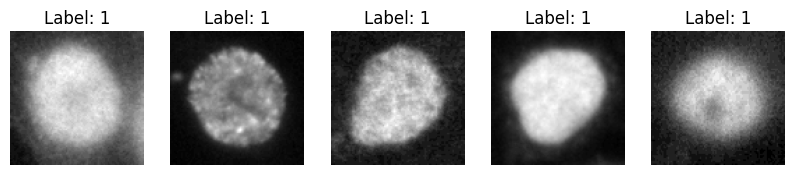

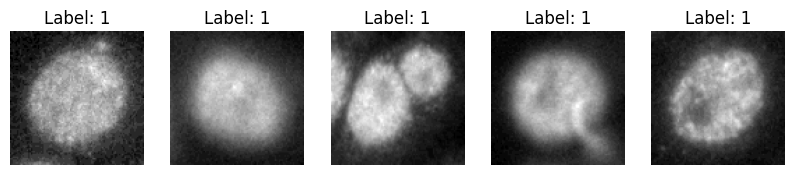

Shape of a training image: (96, 96)
Min and Max pixel values of a training image: 31, 104


In [82]:
import matplotlib.pyplot as plt

# Function to display a few images
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# Display a few training images
display_images(train_images, train_labels)

# Display a few validation images
display_images(val_images, val_labels)

# Display a few testing images
display_images(test_images, test_labels)

# Check the shape and range of pixel values of the images
print(f"Shape of a training image: {train_images[0].shape}")
print(f"Min and Max pixel values of a training image: {train_images[0].min()}, {train_images[0].max()}")

## Section 3. Convert Lists to NumPy Arrays and Display Shapes

In [17]:
# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Display the shapes of the preprocessed image arrays
print(f"Shape of training images: {train_images.shape}")
print(f"Shape of validation images: {val_images.shape}")
print(f"Shape of testing images: {test_images.shape}")

# Ensure that the number of images matches the number of labels in each set
assert train_images.shape[0] == len(train_labels), "Mismatch between number of training images and labels"
assert val_images.shape[0] == len(val_labels), "Mismatch between number of validation images and labels"
assert test_images.shape[0] == len(test_labels), "Mismatch between number of testing images and labels"

Shape of training images: (4000, 96, 96)
Shape of validation images: (3000, 96, 96)
Shape of testing images: (3000, 96, 96)


## Section 4. Save Preprocessed Data as NumPy Arrays

In [17]:
# Save preprocessed data as numpy arrays
np.save('train_images.npy', train_images)
np.save('val_images.npy', val_images)
np.save('test_images.npy', test_images)

# Save labels as numpy arrays
np.save('train_labels.npy', train_labels)
np.save('val_labels.npy', val_labels)
np.save('test_labels.npy', test_labels)

## Section 5. Load Preprocessed Data from NumPy Arrays

In [ ]:
# Load preprocessed data from numpy arrays
train_images = np.load('train_images.npy')
val_images = np.load('val_images.npy')
test_images = np.load('test_images.npy')

# Load labels from numpy arrays
train_labels = np.load('train_labels.npy')
val_labels = np.load('val_labels.npy')
test_labels = np.load('test_labels.npy')

# Extract SIFT Descriptors
Use OpenCV to extract SIFT descriptors from the images.

In [18]:
# Extract SIFT Descriptors

# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Ensure images are in the correct format for SIFT
train_images = (train_images * 255).astype(np.uint8)
val_images = (val_images * 255).astype(np.uint8)
test_images = (test_images * 255).astype(np.uint8)

# Initialize the SIFT detector with further adjusted parameters
sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.01, edgeThreshold=5, sigma=1.2)

# Function to extract SIFT descriptors from an image
def extract_sift_descriptors(image):
    # Check if the image is not empty and has the correct depth
    if image is None or image.dtype != np.uint8:
        print("Invalid image for SIFT descriptor extraction")
        return None
    # Detect SIFT keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Extract SIFT descriptors for training images
train_descriptors = [extract_sift_descriptors(image) for image in train_images]
train_descriptors = [desc for desc in train_descriptors if desc is not None]

# Extract SIFT descriptors for validation images
val_descriptors = [extract_sift_descriptors(image) for image in val_images]
val_descriptors = [desc for desc in val_descriptors if desc is not None]

# Extract SIFT descriptors for testing images
test_descriptors = [extract_sift_descriptors(image) for image in test_images]
test_descriptors = [desc for desc in test_descriptors if desc is not None]

# Calculate percentages of images with descriptors
train_percentage = (len(train_descriptors) / len(train_images)) * 100
val_percentage = (len(val_descriptors) / len(val_images)) * 100
test_percentage = (len(test_descriptors) / len(test_images)) * 100

# Calculate average number of descriptors per image
train_avg_descriptors = np.mean([len(desc) for desc in train_descriptors])
val_avg_descriptors = np.mean([len(desc) for desc in val_descriptors])
test_avg_descriptors = np.mean([len(desc) for desc in test_descriptors])

# Display the statistics
print(f"Number of descriptors for the first training image: {len(train_descriptors[0]) if train_descriptors[0] is not None else 0}")
print(f"Number of training images with descriptors: {len(train_descriptors)} ({train_percentage:.2f}%)")
print(f"Number of validation images with descriptors: {len(val_descriptors)} ({val_percentage:.2f}%)")
print(f"Number of testing images with descriptors: {len(test_descriptors)} ({test_percentage:.2f}%)")
print(f"Average number of descriptors per training image: {train_avg_descriptors:.2f}")
print(f"Average number of descriptors per validation image: {val_avg_descriptors:.2f}")
print(f"Average number of descriptors per testing image: {test_avg_descriptors:.2f}")

# Ensure that descriptors are extracted for all images
assert len(train_descriptors) > 0, "Failed to extract descriptors for all training images"
assert len(val_descriptors) > 0, "Failed to extract descriptors for all validation images"
assert len(test_descriptors) > 0, "Failed to extract descriptors for all testing images"

Number of descriptors for the first training image: 2
Number of training images with descriptors: 3532 (88.30%)
Number of validation images with descriptors: 2637 (87.90%)
Number of testing images with descriptors: 2637 (87.90%)
Average number of descriptors per training image: 8.77
Average number of descriptors per validation image: 8.47
Average number of descriptors per testing image: 8.73


# Build CNN Sequential Model
Build a CNN sequential model using TensorFlow/Keras.

## Build CNN Sequential

In [ ]:
# Build CNN Sequential Model

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

## Build CNN Sequential with Raw Descriptors

In [12]:
# Function to pad descriptors to a fixed size
def pad_descriptors(descriptors, max_descriptors):
    padded_descriptors = np.zeros((max_descriptors, 128))
    if descriptors is not None and len(descriptors) > 0:
        num_desc = min(len(descriptors), max_descriptors)
        padded_descriptors[:num_desc, :] = descriptors[:num_desc, :]
    return padded_descriptors

# Define the maximum number of descriptors
max_descriptors = 10000  # Example size, adjust based on your dataset

# Pad descriptors for training, validation, and testing sets
train_padded = np.array([pad_descriptors(desc, max_descriptors) for desc in train_descriptors])
val_padded = np.array([pad_descriptors(desc, max_descriptors) for desc in val_descriptors])
test_padded = np.array([pad_descriptors(desc, max_descriptors) for desc in test_descriptors])

# Ensure that the number of padded descriptors matches the number of images
train_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in train_descriptors])
val_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in val_descriptors])
test_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in test_descriptors])

# Reshape images to match the input shape of the model
train_images = train_images.reshape((train_images.shape[0], 96, 96, 1))
val_images = val_images.reshape((val_images.shape[0], 96, 96, 1))
test_images = test_images.reshape((test_images.shape[0], 96, 96, 1))

# Concatenate images and padded descriptors
train_combined = np.concatenate((train_images, train_padded.reshape((train_padded.shape[0], 1, max_descriptors, 128))), axis=1)
val_combined = np.concatenate((val_images, val_padded.reshape((val_padded.shape[0], 1, max_descriptors, 128))), axis=1)
test_combined = np.concatenate((test_images, test_padded.reshape((test_padded.shape[0], 1, max_descriptors, 128))), axis=1)

# Define the CNN model
input_shape = (97, max_descriptors, 128)  # Adjust input shape based on the combined input
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

: 

In [19]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate

# Function to pad descriptors to a fixed size
def pad_descriptors(descriptors, max_descriptors):
    padded_descriptors = np.zeros((max_descriptors, 128))
    if descriptors is not None and len(descriptors) > 0:
        num_desc = min(len(descriptors), max_descriptors)
        padded_descriptors[:num_desc, :] = descriptors[:num_desc, :]
    return padded_descriptors

# Define the maximum number of descriptors
max_descriptors = 1000  # Example size, adjust based on your dataset

# Pad descriptors for training, validation, and testing sets
train_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in train_descriptors])
val_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in val_descriptors])
test_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in test_descriptors])

# Ensure that the number of padded descriptors matches the number of images
assert train_padded.shape[0] == train_images.shape[0], "Mismatch between number of training images and padded descriptors"
assert val_padded.shape[0] == val_images.shape[0], "Mismatch between number of validation images and padded descriptors"
assert test_padded.shape[0] == test_images.shape[0], "Mismatch between number of testing images and padded descriptors"

# Reshape images to match the input shape of the model
train_images = train_images.reshape((train_images.shape[0], 96, 96, 1))
val_images = val_images.reshape((val_images.shape[0], 96, 96, 1))
test_images = test_images.reshape((test_images.shape[0], 96, 96, 1))

# Reshape padded descriptors to match the input shape of the model
train_padded = train_padded.reshape((train_padded.shape[0], max_descriptors, 128, 1))
val_padded = val_padded.reshape((val_padded.shape[0], max_descriptors, 128, 1))
test_padded = test_padded.reshape((test_padded.shape[0], max_descriptors, 128, 1))

# Define the CNN model for image data
image_input = Input(shape=(96, 96, 1), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
image_output = Dense(128, activation='relu')(x)

# Define the model for SIFT descriptors
desc_input = Input(shape=(max_descriptors, 128, 1), name='desc_input')
y = Conv2D(32, (3, 3), activation='relu')(desc_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
y = Dense(128, activation='relu')(y)
desc_output = Dense(128, activation='relu')(y)

# Concatenate the outputs of both branches
combined = concatenate([image_output, desc_output])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)

# Define the final model
model = Model(inputs=[image_input, desc_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


AssertionError: Mismatch between number of training images and padded descriptors

# Train the Model
Train the CNN model using the training data.

In [10]:
# Train the Model

# Train the CNN model using the training data
history = model.fit(
    [train_images, train_padded], train_labels,
    epochs=10,
    batch_size=32,
    validation_data=([val_images, val_padded], val_labels)
)

# Display the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 4000, 3532
'y' sizes: 4000


# Evaluate the Model
Evaluate the model using the validation and testing data.

In [ ]:
# Evaluate the Model

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_images, val_labels, verbose=2)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Display confusion matrix for validation data
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

val_predictions = (model.predict(val_images) > 0.5).astype("int32")
val_conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report for validation data
val_class_report = classification_report(val_labels, val_predictions)
print("Classification Report - Validation Data:")
print(val_class_report)

# Display confusion matrix for testing data
test_predictions = (model.predict(test_images) > 0.5).astype("int32")
test_conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Testing Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report for testing data
test_class_report = classification_report(test_labels, test_predictions)
print("Classification Report - Testing Data:")
print(test_class_report)

# Full Code View

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ desc_input          │ (None, 1000, 128, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 94, 94,    │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 998, 126,  │        320 │ desc_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 47, 47,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 499, 63,   │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 45, 45,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 497, 61,   │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 22, 22,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 248, 30,   │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 30976)     │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 476160)    │          0 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,965,056 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │ 60,948,608 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 65,017,345 (248.02 MB)

 Trainable params: 65,017,345 (248.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'desc_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 857ms/step - accuracy: 0.8033 - loss: 0.1772 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 836ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 823ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 823ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 828ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 822ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 841ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 856ms/step - a

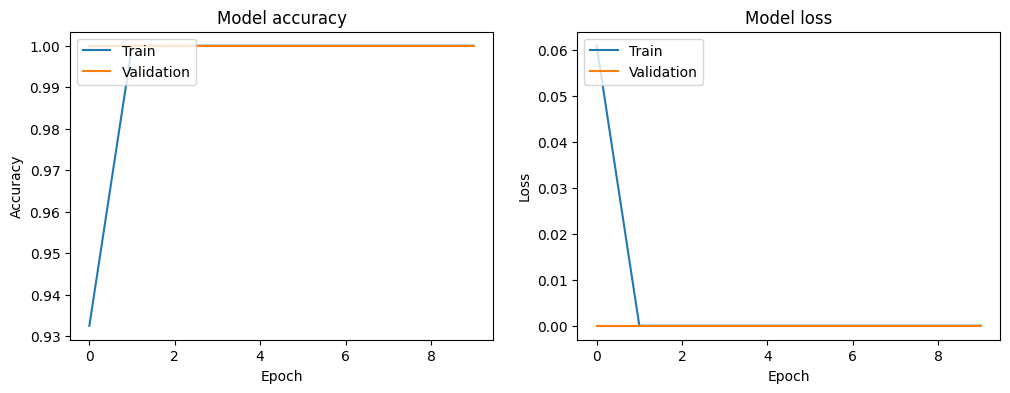

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test accuracy: 1.00


In [66]:
import cv2
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Function to preprocess images: resize, convert to grayscale, and normalize
def preprocess_image_for_sift(image_path, target_size):
    # Read the image from the file
    image = cv2.imread(image_path)
    # Resize the image to the target size
    image_resized = cv2.resize(image, target_size)
    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_gray / 255.0
    # Convert to uint8
    image_uint8 = (image_normalized * 255).astype(np.uint8)
    return image_uint8

# Define the target image size
target_size = (96, 96)  # Example size for MobileNetV2

# Preprocess training images
train_images = [preprocess_image_for_sift(file, target_size) for file in train_files if preprocess_image_for_sift(file, target_size) is not None]

# Preprocess validation images
val_images = [preprocess_image_for_sift(file, target_size) for file in val_files if preprocess_image_for_sift(file, target_size) is not None]

# Preprocess testing images
test_images = [preprocess_image_for_sift(file, target_size) for file in test_files if preprocess_image_for_sift(file, target_size) is not None]

# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Initialize the SIFT detector with further adjusted parameters
sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.01, edgeThreshold=5, sigma=1.2)

# Function to extract SIFT descriptors from an image
def extract_sift_descriptors(image):
    # Check if the image is not empty and has the correct depth
    if image is None or image.dtype != np.uint8:
        print("Invalid image for SIFT descriptor extraction")
        return None
    # Detect SIFT keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Extract SIFT descriptors for training images
train_descriptors = [extract_sift_descriptors(image) for image in train_images]

# Extract SIFT descriptors for validation images
val_descriptors = [extract_sift_descriptors(image) for image in val_images]

# Extract SIFT descriptors for testing images
test_descriptors = [extract_sift_descriptors(image) for image in test_images]

# Function to pad descriptors to a fixed size
def pad_descriptors(descriptors, max_descriptors):
    padded_descriptors = np.zeros((max_descriptors, 128))
    if descriptors is not None and len(descriptors) > 0:
        num_desc = min(len(descriptors), max_descriptors)
        padded_descriptors[:num_desc, :] = descriptors[:num_desc, :]
    return padded_descriptors

# Define the maximum number of descriptors
max_descriptors = 1000  # Example size, adjust based on your dataset

# Ensure that the number of padded descriptors matches the number of images
train_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in train_descriptors])
val_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in val_descriptors])
test_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in test_descriptors])

# Reshape images to match the input shape of the model
train_images = train_images.reshape((train_images.shape[0], 96, 96, 1))
val_images = val_images.reshape((val_images.shape[0], 96, 96, 1))
test_images = test_images.reshape((test_images.shape[0], 96, 96, 1))

# Reshape padded descriptors to match the input shape of the model
train_padded = train_padded.reshape((train_padded.shape[0], max_descriptors, 128, 1))
val_padded = val_padded.reshape((val_padded.shape[0], max_descriptors, 128, 1))
test_padded = test_padded.reshape((test_padded.shape[0], max_descriptors, 128, 1))

# Define the CNN model for image data
image_input = Input(shape=(96, 96, 1), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
image_output = Dense(128, activation='relu')(x)

# Define the model for SIFT descriptors
desc_input = Input(shape=(max_descriptors, 128, 1), name='desc_input')
y = Conv2D(32, (3, 3), activation='relu')(desc_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
y = Dense(128, activation='relu')(y)
desc_output = Dense(128, activation='relu')(y)

# Concatenate the outputs of both branches
combined = concatenate([image_output, desc_output])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)

# Define the final model
model = Model(inputs=[image_input, desc_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    [train_images, train_padded], train_labels,
    epochs=10,
    batch_size=32,
    validation_data=([val_images, val_padded], val_labels)
)

# Display the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate([test_images, test_padded], test_labels)
print(f"Test accuracy: {test_accuracy:.2f}")

In [20]:
# Import necessary libraries
import os
import numpy as np
import scipy.io
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load File Names and Labels

# Load file names from cells2.txt
with open('cells2.txt', 'r') as file:
    file_names = file.read().splitlines()

# Load labels from labels.mat using SciPy
labels = scipy.io.loadmat('labels.mat')['labels'].flatten()

# Display the number of file names and labels loaded
print(f"Number of file names loaded: {len(file_names)}")
print(f"Number of labels loaded: {len(labels)}")

# Ensure that the number of file names matches the number of labels
assert len(file_names) == len(labels), "Mismatch between number of file names and labels"

# Filter the file names to ensure they are within the range 1-10,000
filtered_file_names = [file for file in file_names if int(os.path.basename(file).split('.')[0]) <= 10000]

# Select the first 10,000 images from the filtered dataset
selected_file_names = filtered_file_names[:10000]
selected_labels = labels[:10000]

# Display the number of selected file names and labels
print(f"Number of selected file names: {len(selected_file_names)}")
print(f"Number of selected labels: {len(selected_labels)}")

# Ensure that the number of selected file names matches the number of selected labels
assert len(selected_file_names) == len(selected_labels), "Mismatch between number of selected file names and labels"

# Split Data into Training, Validation, and Testing Sets

# Split the selected file names and labels into training, validation, and testing sets
train_files, temp_files, train_labels, temp_labels = train_test_split(
    selected_file_names, selected_labels, test_size=0.6, random_state=42)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42)

# Display the number of files in each set
print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")
print(f"Number of testing files: {len(test_files)}")

# Ensure that the total number of files matches the number of selected files
assert len(train_files) + len(val_files) + len(test_files) == len(selected_file_names), "Mismatch in total number of files after splitting"

# Define the target image size
target_size = (96, 96)

# Function to preprocess images: resize, convert to grayscale, and normalize
def preprocess_image_for_sift(image_path, target_size):
    # Read the image from the file
    image = cv2.imread(image_path)
    # Check if the image was read correctly
    if image is None:
        print(f"Error reading image: {image_path}")
        return None
    # Resize the image to the target size
    image_resized = cv2.resize(image, target_size)
    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_gray / 255.0
    # Convert to uint8
    image_uint8 = (image_normalized * 255).astype(np.uint8)
    return image_uint8

# Preprocess training images
train_images = [preprocess_image_for_sift(file, target_size) for file in train_files if preprocess_image_for_sift(file, target_size) is not None]

# Preprocess validation images
val_images = [preprocess_image_for_sift(file, target_size) for file in val_files if preprocess_image_for_sift(file, target_size) is not None]

# Preprocess testing images
test_images = [preprocess_image_for_sift(file, target_size) for file in test_files if preprocess_image_for_sift(file, target_size) is not None]

# Count the number of successfully preprocessed images
print(f"Number of successfully preprocessed training images: {len(train_images)}")
print(f"Number of successfully preprocessed validation images: {len(val_images)}")
print(f"Number of successfully preprocessed testing images: {len(test_images)}")

# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Display the shapes of the preprocessed image arrays
print(f"Shape of training images: {train_images.shape}")
print(f"Shape of validation images: {val_images.shape}")
print(f"Shape of testing images: {test_images.shape}")

# Ensure that the number of images matches the number of labels in each set
assert train_images.shape[0] == len(train_labels), "Mismatch between number of training images and labels"
assert val_images.shape[0] == len(val_labels), "Mismatch between number of validation images and labels"
assert test_images.shape[0] == len(test_labels), "Mismatch between number of testing images and labels"

# Extract SIFT Descriptors

# Ensure images are in the correct format for SIFT
train_images = (train_images * 255).astype(np.uint8)
val_images = (val_images * 255).astype(np.uint8)
test_images = (test_images * 255).astype(np.uint8)

# Initialize the SIFT detector with further adjusted parameters
sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.01, edgeThreshold=5, sigma=1.2)

# Function to extract SIFT descriptors from an image
def extract_sift_descriptors(image):
    # Check if the image is not empty and has the correct depth
    if image is None or image.dtype != np.uint8:
        print("Invalid image for SIFT descriptor extraction")
        return None
    # Detect SIFT keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Extract SIFT descriptors for training images
train_descriptors = [extract_sift_descriptors(image) for image in train_images]
train_descriptors = [desc for desc in train_descriptors if desc is not None]

# Extract SIFT descriptors for validation images
val_descriptors = [extract_sift_descriptors(image) for image in val_images]
val_descriptors = [desc for desc in val_descriptors if desc is not None]

# Extract SIFT descriptors for testing images
test_descriptors = [extract_sift_descriptors(image) for image in test_images]
test_descriptors = [desc for desc in test_descriptors if desc is not None]

# Calculate percentages of images with descriptors
train_percentage = (len(train_descriptors) / len(train_images)) * 100
val_percentage = (len(val_descriptors) / len(val_images)) * 100
test_percentage = (len(test_descriptors) / len(test_images)) * 100

# Calculate average number of descriptors per image
train_avg_descriptors = np.mean([len(desc) for desc in train_descriptors])
val_avg_descriptors = np.mean([len(desc) for desc in val_descriptors])
test_avg_descriptors = np.mean([len(desc) for desc in test_descriptors])

# Display the statistics
print(f"Number of descriptors for the first training image: {len(train_descriptors[0]) if train_descriptors[0] is not None else 0}")
print(f"Number of training images with descriptors: {len(train_descriptors)} ({train_percentage:.2f}%)")
print(f"Number of validation images with descriptors: {len(val_descriptors)} ({val_percentage:.2f}%)")
print(f"Number of testing images with descriptors: {len(test_descriptors)} ({test_percentage:.2f}%)")
print(f"Average number of descriptors per training image: {train_avg_descriptors:.2f}")
print(f"Average number of descriptors per validation image: {val_avg_descriptors:.2f}")
print(f"Average number of descriptors per testing image: {test_avg_descriptors:.2f}")

# Ensure that descriptors are extracted for all images
assert len(train_descriptors) > 0, "Failed to extract descriptors for all training images"
assert len(val_descriptors) > 0, "Failed to extract descriptors for all validation images"
assert len(test_descriptors) > 0, "Failed to extract descriptors for all testing images"

# Function to pad descriptors to a fixed size
def pad_descriptors(descriptors, max_descriptors):
    padded_descriptors = np.zeros((max_descriptors, 128))
    if descriptors is not None and len(descriptors) > 0:
        num_desc = min(len(descriptors), max_descriptors)
        padded_descriptors[:num_desc, :] = descriptors[:num_desc, :]
    return padded_descriptors

# Define the maximum number of descriptors
max_descriptors = 1000  # Example size, adjust based on your dataset

# Pad descriptors for training, validation, and testing sets
train_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in train_descriptors])
val_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in val_descriptors])
test_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in test_descriptors])

# Ensure that the number of padded descriptors matches the number of images
assert train_padded.shape[0] == train_images.shape[0], "Mismatch between number of training images and padded descriptors"
assert val_padded.shape[0] == val_images.shape[0], "Mismatch between number of validation images and padded descriptors"
assert test_padded.shape[0] == test_images.shape[0], "Mismatch between number of testing images and padded descriptors"

# Reshape images to match the input shape of the model
train_images = train_images.reshape((train_images.shape[0], 96, 96, 1))
val_images = val_images.reshape((val_images.shape[0], 96, 96, 1))
test_images = test_images.reshape((test_images.shape[0], 96, 96, 1))

# Reshape padded descriptors to match the input shape of the model
train_padded = train_padded.reshape((train_padded.shape[0], max_descriptors, 128, 1))
val_padded = val_padded.reshape((val_padded.shape[0], max_descriptors, 128, 1))
test_padded = test_padded.reshape((test_padded.shape[0], max_descriptors, 128, 1))

# Define the CNN model for image data
image_input = Input(shape=(96, 96, 1), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
image_output = Dense(128, activation='relu')(x)

# Define the model for SIFT descriptors
desc_input = Input(shape=(max_descriptors, 128, 1), name='desc_input')
y = Conv2D(32, (3, 3), activation='relu')(desc_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
y = Dense(128, activation='relu')(y)
desc_output = Dense(128, activation='relu')(y)

# Concatenate the outputs of both branches
combined = concatenate([image_output, desc_output])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)

# Define the final model
model = Model(inputs=[image_input, desc_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the Model

# Train the CNN model using the training data
history = model.fit(
    [train_images, train_padded], train_labels,
    epochs=10,
    batch_size=32,
    validation_data=([val_images, val_padded], val_labels)
)

# Display the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Number of file names loaded: 63445
Number of labels loaded: 63445
Number of selected file names: 10000
Number of selected labels: 10000
Number of training files: 4000
Number of validation files: 3000
Number of testing files: 3000
Number of successfully preprocessed training images: 4000
Number of successfully preprocessed validation images: 3000
Number of successfully preprocessed testing images: 3000
Shape of training images: (4000, 96, 96)
Shape of validation images: (3000, 96, 96)
Shape of testing images: (3000, 96, 96)
Number of descriptors for the first training image: 2
Number of training images with descriptors: 3532 (88.30%)
Number of validation images with descriptors: 2637 (87.90%)
Number of testing images with descriptors: 2637 (87.90%)
Average number of descriptors per training image: 8.77
Average number of descriptors per validation image: 8.47
Average number of descriptors per testing image: 8.73


AssertionError: Mismatch between number of training images and padded descriptors

In [1]:
# Import necessary libraries
import os
import numpy as np
import scipy.io
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load File Names and Labels

# Load file names from cells2.txt
with open('cells2.txt', 'r') as file:
    file_names = file.read().splitlines()

# Load labels from labels.mat using SciPy
labels = scipy.io.loadmat('labels.mat')['labels'].flatten()

# Display the number of file names and labels loaded
print(f"Number of file names loaded: {len(file_names)}")
print(f"Number of labels loaded: {len(labels)}")

# Ensure that the number of file names matches the number of labels
assert len(file_names) == len(labels), "Mismatch between number of file names and labels"

# Filter the file names to ensure they are within the range 1-10,000
filtered_file_names = [file for file in file_names if int(os.path.basename(file).split('.')[0]) <= 10000]

# Select the first 10,000 images from the filtered dataset
selected_file_names = filtered_file_names[:10000]
selected_labels = labels[:10000]

# Display the number of selected file names and labels
print(f"Number of selected file names: {len(selected_file_names)}")
print(f"Number of selected labels: {len(selected_labels)}")

# Ensure that the number of selected file names matches the number of selected labels
assert len(selected_file_names) == len(selected_labels), "Mismatch between number of selected file names and labels"

# Split Data into Training, Validation, and Testing Sets

# Split the selected file names and labels into training, validation, and testing sets
train_files, temp_files, train_labels, temp_labels = train_test_split(
    selected_file_names, selected_labels, test_size=0.6, random_state=42)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42)

# Display the number of files in each set
print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")
print(f"Number of testing files: {len(test_files)}")

# Ensure that the total number of files matches the number of selected files
assert len(train_files) + len(val_files) + len(test_files) == len(selected_file_names), "Mismatch in total number of files after splitting"

# Define the target image size
target_size = (96, 96)

# Function to preprocess images: resize, convert to grayscale, and normalize
def preprocess_image_for_sift(image_path, target_size):
    # Read the image from the file
    image = cv2.imread(image_path)
    # Check if the image was read correctly
    if image is None:
        print(f"Error reading image: {image_path}")
        return None
    # Resize the image to the target size
    image_resized = cv2.resize(image, target_size)
    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_gray / 255.0
    # Convert to uint8
    image_uint8 = (image_normalized * 255).astype(np.uint8)
    return image_uint8

# Preprocess training images
train_images = [preprocess_image_for_sift(file, target_size) for file in train_files if preprocess_image_for_sift(file, target_size) is not None]

# Preprocess validation images
val_images = [preprocess_image_for_sift(file, target_size) for file in val_files if preprocess_image_for_sift(file, target_size) is not None]

# Preprocess testing images
test_images = [preprocess_image_for_sift(file, target_size) for file in test_files if preprocess_image_for_sift(file, target_size) is not None]

# Count the number of successfully preprocessed images
print(f"Number of successfully preprocessed training images: {len(train_images)}")
print(f"Number of successfully preprocessed validation images: {len(val_images)}")
print(f"Number of successfully preprocessed testing images: {len(test_images)}")

# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Display the shapes of the preprocessed image arrays
print(f"Shape of training images: {train_images.shape}")
print(f"Shape of validation images: {val_images.shape}")
print(f"Shape of testing images: {test_images.shape}")

# Ensure that the number of images matches the number of labels in each set
assert train_images.shape[0] == len(train_labels), "Mismatch between number of training images and labels"
assert val_images.shape[0] == len(val_labels), "Mismatch between number of validation images and labels"
assert test_images.shape[0] == len(test_labels), "Mismatch between number of testing images and labels"

# Extract SIFT Descriptors

# Ensure images are in the correct format for SIFT
train_images = (train_images * 255).astype(np.uint8)
val_images = (val_images * 255).astype(np.uint8)
test_images = (test_images * 255).astype(np.uint8)

# Initialize the SIFT detector with further adjusted parameters
sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.01, edgeThreshold=5, sigma=1.2)

# Function to extract SIFT descriptors from an image
def extract_sift_descriptors(image):
    # Check if the image is not empty and has the correct depth
    if image is None or image.dtype != np.uint8:
        print("Invalid image for SIFT descriptor extraction")
        return None
    # Detect SIFT keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Extract SIFT descriptors for training images
train_descriptors = [extract_sift_descriptors(image) for image in train_images]
train_descriptors = [desc for desc in train_descriptors if desc is not None]

# Extract SIFT descriptors for validation images
val_descriptors = [extract_sift_descriptors(image) for image in val_images]
val_descriptors = [desc for desc in val_descriptors if desc is not None]

# Extract SIFT descriptors for testing images
test_descriptors = [extract_sift_descriptors(image) for image in test_images]
test_descriptors = [desc for desc in test_descriptors if desc is not None]

# Filter images and labels to match the descriptors
train_images = train_images[:len(train_descriptors)]
train_labels = train_labels[:len(train_descriptors)]
val_images = val_images[:len(val_descriptors)]
val_labels = val_labels[:len(val_descriptors)]
test_images = test_images[:len(test_descriptors)]
test_labels = test_labels[:len(test_descriptors)]

# Calculate percentages of images with descriptors
train_percentage = (len(train_descriptors) / len(train_images)) * 100
val_percentage = (len(val_descriptors) / len(val_images)) * 100
test_percentage = (len(test_descriptors) / len(test_images)) * 100

# Calculate average number of descriptors per image
train_avg_descriptors = np.mean([len(desc) for desc in train_descriptors])
val_avg_descriptors = np.mean([len(desc) for desc in val_descriptors])
test_avg_descriptors = np.mean([len(desc) for desc in test_descriptors])

# Display the statistics
print(f"Number of descriptors for the first training image: {len(train_descriptors[0]) if train_descriptors[0] is not None else 0}")
print(f"Number of training images with descriptors: {len(train_descriptors)} ({train_percentage:.2f}%)")
print(f"Number of validation images with descriptors: {len(val_descriptors)} ({val_percentage:.2f}%)")
print(f"Number of testing images with descriptors: {len(test_descriptors)} ({test_percentage:.2f}%)")
print(f"Average number of descriptors per training image: {train_avg_descriptors:.2f}")
print(f"Average number of descriptors per validation image: {val_avg_descriptors:.2f}")
print(f"Average number of descriptors per testing image: {test_avg_descriptors:.2f}")

# Ensure that descriptors are extracted for all images
assert len(train_descriptors) > 0, "Failed to extract descriptors for all training images"
assert len(val_descriptors) > 0, "Failed to extract descriptors for all validation images"
assert len(test_descriptors) > 0, "Failed to extract descriptors for all testing images"

# Function to pad descriptors to a fixed size
def pad_descriptors(descriptors, max_descriptors):
    padded_descriptors = np.zeros((max_descriptors, 128))
    if descriptors is not None and len(descriptors) > 0:
        num_desc = min(len(descriptors), max_descriptors)
        padded_descriptors[:num_desc, :] = descriptors[:num_desc, :]
    return padded_descriptors

# Define the maximum number of descriptors
max_descriptors = 1000  # Example size, adjust based on your dataset

# Pad descriptors for training, validation, and testing sets
train_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in train_descriptors])
val_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in val_descriptors])
test_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in test_descriptors])

# Ensure that the number of padded descriptors matches the number of images
assert train_padded.shape[0] == train_images.shape[0], "Mismatch between number of training images and padded descriptors"
assert val_padded.shape[0] == val_images.shape[0], "Mismatch between number of validation images and padded descriptors"
assert test_padded.shape[0] == test_images.shape[0], "Mismatch between number of testing images and padded descriptors"

# Reshape images to match the input shape of the model
train_images = train_images.reshape((train_images.shape[0], 96, 96, 1))
val_images = val_images.reshape((val_images.shape[0], 96, 96, 1))
test_images = test_images.reshape((test_images.shape[0], 96, 96, 1))

# Reshape padded descriptors to match the input shape of the model
train_padded = train_padded.reshape((train_padded.shape[0], max_descriptors, 128, 1))
val_padded = val_padded.reshape((val_padded.shape[0], max_descriptors, 128, 1))
test_padded = test_padded.reshape((test_padded.shape[0], max_descriptors, 128, 1))

# Define the CNN model for image data
image_input = Input(shape=(96, 96, 1), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
image_output = Dense(128, activation='relu')(x)

# Define the model for SIFT descriptors
desc_input = Input(shape=(max_descriptors, 128, 1), name='desc_input')
y = Conv2D(32, (3, 3), activation='relu')(desc_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
y = Dense(128, activation='relu')(y)
desc_output = Dense(128, activation='relu')(y)

# Concatenate the outputs of both branches
combined = concatenate([image_output, desc_output])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)

# Define the final model
model = Model(inputs=[image_input, desc_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the Model

# Train the CNN model using the training data
history = model.fit(
    [train_images, train_padded], train_labels,
    epochs=10,
    batch_size=32,
    validation_data=([val_images, val_padded], val_labels)
)

# Display the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Number of file names loaded: 63445
Number of labels loaded: 63445
Number of selected file names: 10000
Number of selected labels: 10000
Number of training files: 4000
Number of validation files: 3000
Number of testing files: 3000
Number of successfully preprocessed training images: 4000
Number of successfully preprocessed validation images: 3000
Number of successfully preprocessed testing images: 3000
Shape of training images: (4000, 96, 96)
Shape of validation images: (3000, 96, 96)
Shape of testing images: (3000, 96, 96)
Number of descriptors for the first training image: 2
Number of training images with descriptors: 3532 (100.00%)
Number of validation images with descriptors: 2637 (100.00%)
Number of testing images with descriptors: 2637 (100.00%)
Average number of descriptors per training image: 8.77
Average number of descriptors per validation image: 8.47
Average number of descriptors per testing image: 8.73


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ desc_input          │ (None, 1000, 128, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 94, 94,    │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 998, 126,  │        320 │ desc_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 47, 47,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 499, 63,   │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 497, 61,   │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 22, 22,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 248, 30,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 30976)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 476160)    │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  3,965,056 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │ 60,948,608 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 65,017,345 (248.02 MB)

 Trainable params: 65,017,345 (248.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'desc_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


111/111 ━━━━━━━━━━━━━━━━━━━━ 96s 854ms/step - accuracy: 0.9527 - loss: 0.2305 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
 21/111 ━━━━━━━━━━━━━━━━━━━━ 1:07 748ms/step - accuracy: 1.0000 - loss: 0.0000e+00

KeyboardInterrupt: 

In [2]:
import os
import numpy as np
import scipy.io
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Input, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

# Load File Names and Labels

# Load file names from GitHub
github_url = "https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/hep2cell/cells2.txt"
response = requests.get(github_url)
file_names = response.text.splitlines()

# Load labels from labels.mat using SciPy
labels_url = "https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/hep2cell/labels.mat"
labels_path = tf.keras.utils.get_file("labels.mat", labels_url)
labels = scipy.io.loadmat(labels_path)['labels'].flatten()

# Display the number of file names and labels loaded
print(f"Number of file names loaded: {len(file_names)}")
print(f"Number of labels loaded: {len(labels)}")

# Ensure that the number of file names matches the number of labels
assert len(file_names) == len(labels), "Mismatch between number of file names and labels"

# Filter the file names to ensure they are within the range 1-10,000
filtered_file_names = [file for file in file_names if int(os.path.basename(file).split('.')[0]) <= 10000]

# Select the first 10,000 images from the filtered dataset
selected_file_names = filtered_file_names[:10000]
selected_labels = labels[:10000]

# Display the number of selected file names and labels
print(f"Number of selected file names: {len(selected_file_names)}")
print(f"Number of selected labels: {len(selected_labels)}")

# Ensure that the number of selected file names matches the number of selected labels
assert len(selected_file_names) == len(selected_labels), "Mismatch between number of selected file names and labels"

# Split Data into Training, Validation, and Testing Sets

# Split the selected file names and labels into training, validation, and testing sets
train_files, temp_files, train_labels, temp_labels = train_test_split(
    selected_file_names, selected_labels, test_size=0.6, random_state=42)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42)

# Display the number of files in each set
print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")
print(f"Number of testing files: {len(test_files)}")

# Ensure that the total number of files matches the number of selected files
assert len(train_files) + len(val_files) + len(test_files) == len(selected_file_names), "Mismatch in total number of files after splitting"

# Define the target image size
target_size = (96, 96)

# Function to download and preprocess images: resize, convert to grayscale, and normalize
def preprocess_image_for_sift(image_url, target_size):
    # Download the image from the URL
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    # Convert the image to RGB
    image = image.convert('RGB')
    # Resize the image to the target size
    image_resized = image.resize(target_size)
    # Convert the image to grayscale
    image_gray = image_resized.convert('L')
    # Normalize the pixel values to the range [0, 1]
    image_normalized = np.array(image_gray) / 255.0
    # Convert to uint8
    image_uint8 = (image_normalized * 255).astype(np.uint8)
    return image_uint8

# Preprocess training images
train_images = [preprocess_image_for_sift(f"https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/hep2cell/{file}", target_size) for file in train_files]

# Preprocess validation images
val_images = [preprocess_image_for_sift(f"https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/hep2cell/{file}", target_size) for file in val_files]

# Preprocess testing images
test_images = [preprocess_image_for_sift(f"https://raw.githubusercontent.com/RyanS974/RyanS974/main/datasets/hep2cell/{file}", target_size) for file in test_files]

# Count the number of successfully preprocessed images
print(f"Number of successfully preprocessed training images: {len(train_images)}")
print(f"Number of successfully preprocessed validation images: {len(val_images)}")
print(f"Number of successfully preprocessed testing images: {len(test_images)}")

# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Display the shapes of the preprocessed image arrays
print(f"Shape of training images: {train_images.shape}")
print(f"Shape of validation images: {val_images.shape}")
print(f"Shape of testing images: {test_images.shape}")

# Ensure that the number of images matches the number of labels in each set
assert train_images.shape[0] == len(train_labels), "Mismatch between number of training images and labels"
assert val_images.shape[0] == len(val_labels), "Mismatch between number of validation images and labels"
assert test_images.shape[0] == len(test_labels), "Mismatch between number of testing images and labels"

# Extract SIFT Descriptors

# Ensure images are in the correct format for SIFT
train_images = (train_images * 255).astype(np.uint8)
val_images = (val_images * 255).astype(np.uint8)
test_images = (test_images * 255).astype(np.uint8)

# Initialize the SIFT detector with further adjusted parameters
sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.01, edgeThreshold=5, sigma=1.2)

# Function to extract SIFT descriptors from an image
def extract_sift_descriptors(image):
    # Check if the image is not empty and has the correct depth
    if image is None or image.dtype != np.uint8:
        print("Invalid image for SIFT descriptor extraction")
        return None
    # Detect SIFT keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# Extract SIFT descriptors for training images
train_descriptors = [extract_sift_descriptors(image)[1] for image in train_images]
train_descriptors = [desc for desc in train_descriptors if desc is not None]

# Extract SIFT descriptors for validation images
val_descriptors = [extract_sift_descriptors(image)[1] for image in val_images]
val_descriptors = [desc for desc in val_descriptors if desc is not None]

# Extract SIFT descriptors for testing images
test_descriptors = [extract_sift_descriptors(image)[1] for image in test_images]
test_descriptors = [desc for desc in test_descriptors if desc is not None]

# Filter images and labels to match the descriptors
train_images = train_images[:len(train_descriptors)]
train_labels = train_labels[:len(train_descriptors)]
val_images = val_images[:len(val_descriptors)]
val_labels = val_labels[:len(val_descriptors)]
test_images = test_images[:len(test_descriptors)]
test_labels = test_labels[:len(test_descriptors)]

# Calculate percentages of images with descriptors
train_percentage = (len(train_descriptors) / len(train_images)) * 100
val_percentage = (len(val_descriptors) / len(val_images)) * 100
test_percentage = (len(test_descriptors) / len(test_images)) * 100

# Calculate average number of descriptors per image
train_avg_descriptors = np.mean([len(desc) for desc in train_descriptors])
val_avg_descriptors = np.mean([len(desc) for desc in val_descriptors])
test_avg_descriptors = np.mean([len(desc) for desc in test_descriptors])

# Display the statistics
print(f"Number of descriptors for the first training image: {len(train_descriptors[0]) if train_descriptors[0] is not None else 0}")
print(f"Number of training images with descriptors: {len(train_descriptors)} ({train_percentage:.2f}%)")
print(f"Number of validation images with descriptors: {len(val_descriptors)} ({val_percentage:.2f}%)")
print(f"Number of testing images with descriptors: {len(test_descriptors)} ({test_percentage:.2f}%)")
print(f"Average number of descriptors per training image: {train_avg_descriptors:.2f}")
print(f"Average number of descriptors per validation image: {val_avg_descriptors:.2f}")
print(f"Average number of descriptors per testing image: {test_avg_descriptors:.2f}")

# Ensure that descriptors are extracted for all images
assert len(train_descriptors) > 0, "Failed to extract descriptors for all training images"
assert len(val_descriptors) > 0, "Failed to extract descriptors for all validation images"
assert len(test_descriptors) > 0, "Failed to extract descriptors for all testing images"

# Function to pad descriptors to a fixed size
def pad_descriptors(descriptors, max_descriptors):
    padded_descriptors = np.zeros((max_descriptors, 128))
    if descriptors is not None and len(descriptors) > 0:
        num_desc = min(len(descriptors), max_descriptors)
        padded_descriptors[:num_desc, :] = descriptors[:num_desc, :]
    return padded_descriptors

# Define the maximum number of descriptors
max_descriptors = 4000  # Adjust based on your dataset

# Pad descriptors for training, validation, and testing sets
train_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in train_descriptors])
val_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in val_descriptors])
test_padded = np.array([pad_descriptors(desc, max_descriptors) if desc is not None else np.zeros((max_descriptors, 128)) for desc in test_descriptors])

# Ensure that the number of padded descriptors matches the number of images
assert train_padded.shape[0] == train_images.shape[0], "Mismatch between number of training images and padded descriptors"
assert val_padded.shape[0] == val_images.shape[0], "Mismatch between number of validation images and padded descriptors"
assert test_padded.shape[0] == test_images.shape[0], "Mismatch between number of testing images and padded descriptors"

# Reshape images to match the input shape of the model
train_images = train_images.reshape((train_images.shape[0], 96, 96, 1))
val_images = val_images.reshape((val_images.shape[0], 96, 96, 1))
test_images = test_images.reshape((test_images.shape[0], 96, 96, 1))

# Reshape padded descriptors to match the input shape of the model
train_padded = train_padded.reshape((train_padded.shape[0], max_descriptors, 128, 1))
val_padded = val_padded.reshape((val_padded.shape[0], max_descriptors, 128, 1))
test_padded = test_padded.reshape((test_padded.shape[0], max_descriptors, 128, 1))

# Define the CNN model for image data
image_input = Input(shape=(96, 96, 1), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
image_output = Dense(128, activation='relu')(x)

# Define the model for SIFT descriptors
desc_input = Input(shape=(max_descriptors, 128, 1), name='desc_input')
y = Conv2D(32, (3, 3), activation='relu')(desc_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
y = Dense(128, activation='relu')(y)
desc_output = Dense(128, activation='relu')(y)

# Concatenate the outputs of both branches
combined = concatenate([image_output, desc_output])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)  # Add dropout for regularization
z = Dense(1, activation='sigmoid')(z)

# Define the final model
model = Model(inputs=[image_input, desc_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the Model

# Train the CNN model using the training data
history = model.fit(
    [train_images, train_padded], train_labels,
    epochs=10,
    batch_size=32,
    validation_data=([val_images, val_padded], val_labels)
)

# Display the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Visualize SIFT Descriptors

# Function to visualize SIFT descriptors on images
def visualize_sift(image, keypoints, max_descriptors=5):
    overlay = cv2.drawKeypoints(image, keypoints[:max_descriptors], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(overlay, cmap='gray')
    plt.axis('off')
    plt.show()

# Visualize SIFT descriptors for 3 images
for i in range(3):
    keypoints, _ = extract_sift_descriptors(train_images[i])
    visualize_sift(train_images[i], keypoints)

Number of file names loaded: 63445
Number of labels loaded: 63445
Number of selected file names: 10000
Number of selected labels: 10000
Number of training files: 4000
Number of validation files: 3000
Number of testing files: 3000


KeyboardInterrupt: 